# Dataset Loading

The dataset is a filtered ParaNMT-detox corpus (500K sentence pairs). It was loaded from [here](https://github.com/s-nlp/detox/tree/main#parallel-detoxification-corpus).

In [1]:
%cd ..
from src.data.make_dataset import unzip_ds, load_df, preprocess
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

/Users/leiluk1/innopolis/text-detoxification


In [2]:
zip_dataset_path = './data/raw/filtered_paranmt.zip'
extract_path = './data/raw/'

unzip_ds(zip_dataset_path, extract_path)

In [3]:
dataset_path = './data/raw/filtered.tsv'

df = load_df(dataset_path)

In [4]:
df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577777 entries, 0 to 577776
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   reference    577777 non-null  object 
 1   translation  577777 non-null  object 
 2   similarity   577777 non-null  float64
 3   lenght_diff  577777 non-null  float64
 4   ref_tox      577777 non-null  float64
 5   trn_tox      577777 non-null  float64
dtypes: float64(4), object(2)
memory usage: 26.4+ MB


# Data exploration & Preprocessing

## Dataset description 

The dataset is the filtered ParaNMT-detox corpus (approximately 600K sentence pairs) that is a subset of the ParaNMT corpus (50M sentence pairs). 

The dataset consists of the following columns:
- `reference` —  first item from the pair;
- `translation` —  second item from the pair (paraphrazed version of the reference);
- `similarity` —  cosine similarity of the sentence pairs;
- `lenght_diff` —  relative length difference between texts;
- `ref_tox` —  toxicity level of reference text;
- `trn_tox` —  toxicity level of translation text.


In [6]:
print('Missing values:', df.isna().sum().sum())

Missing values: 0


In [7]:
numerical_columns = df.select_dtypes(exclude='object').columns.tolist()
df[numerical_columns].describe()

,similarity,lenght_diff,ref_tox,trn_tox
count,577777.000000,577777.000000,577777.000000,577777.000000
mean,0.758469,0.157652,0.541372,0.434490
std,0.092695,0.108057,0.457571,0.458904
min,0.600001,0.000000,0.000033,0.000033
25%,0.681105,0.066667,0.012171,0.000707
50%,0.754439,0.141791,0.806795,0.085133
75%,0.831244,0.238095,0.990469,0.973739
max,0.950000,0.400000,0.999724,0.999730


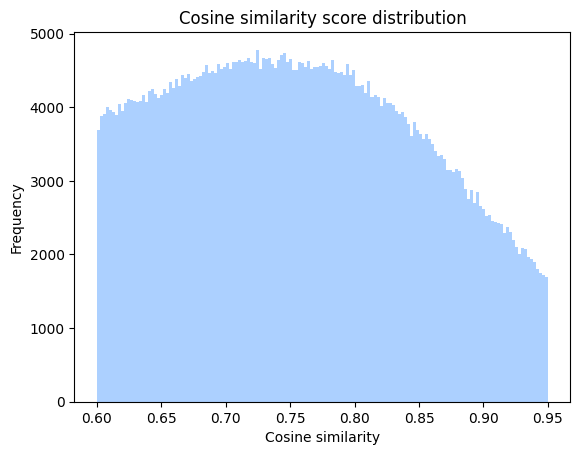

In [8]:
# Plot cosine similarity score distribution
def plot_similarity(df, bins=150):
    plt.hist(df['similarity'], alpha=0.6, bins=bins, color='#75b1ff')
    plt.title('Cosine similarity score distribution')
    plt.xlabel('Cosine similarity')
    plt.ylabel('Frequency')
    plt.show()
    
    
plot_similarity(df)

As can be seen from the plot above, the cosine similarity scores between the sentence pairs are high, ranging from **0.6** to **0.95**.

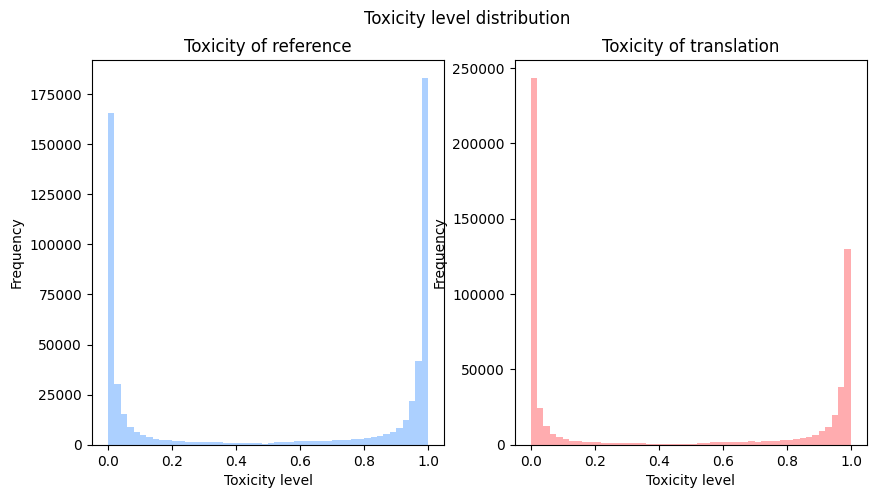

In [9]:
# Plot toxicity level distribution for references and translations
def plot_tox_levels(df, bins=50, columns=['ref_tox', 'trn_tox']):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    titles = ['Toxicity of reference', 'Toxicity of translation']
    colors = ['#75b1ff', '#ff757a']
    
    for i, ax in enumerate(axs):
        ax.hist(df[columns[i]], alpha=0.6, bins=bins, color=colors[i])
        ax.set_title(titles[i])
        ax.set_xlabel('Toxicity level')
        ax.set_ylabel('Frequency')
    
    fig.suptitle('Toxicity level distribution')
    plt.show()
    
    
plot_tox_levels(df)

In [10]:
ratio = (df['ref_tox'] < df['trn_tox']).mean()
print(f'The ratio of translations that more toxic than references is {ratio * 100:.0f}%')

The ratio of translations that more toxic than references is 45%


As was obtained, the translations have higher toxicity level that reference sentences in approximately 45% of the cases, which should be taken into account. 


## Dataset preprocessing

Let's preprocess the data in order to have the one column with reference (toxic) sentence and another column with its paraphrazed (non-toxic) version:

In [11]:
preprocessed_df = preprocess(df)

In [12]:
preprocessed_df.head()

,reference,detox_reference,similarity,lenght_diff,ref_tox,detox_ref_tox
0,"if Alkar floods her with her mental waste, it ...","If Alkar is flooding her with psychic waste, t...",0.785171,0.010309,0.981983,0.014195
1,you're becoming disgusting.,Now you're getting nasty.,0.749687,0.071429,0.999039,0.065473
2,"well, we can spare your life.","Well, we could spare your life, for one.",0.919051,0.268293,0.985068,0.213313
3,"monkey, you have to wake up.","Ah! Monkey, you've got to snap out of it.",0.664333,0.309524,0.994215,0.053362
4,I have orders to kill her.,I've got orders to put her down.,0.726639,0.181818,0.999348,0.009402


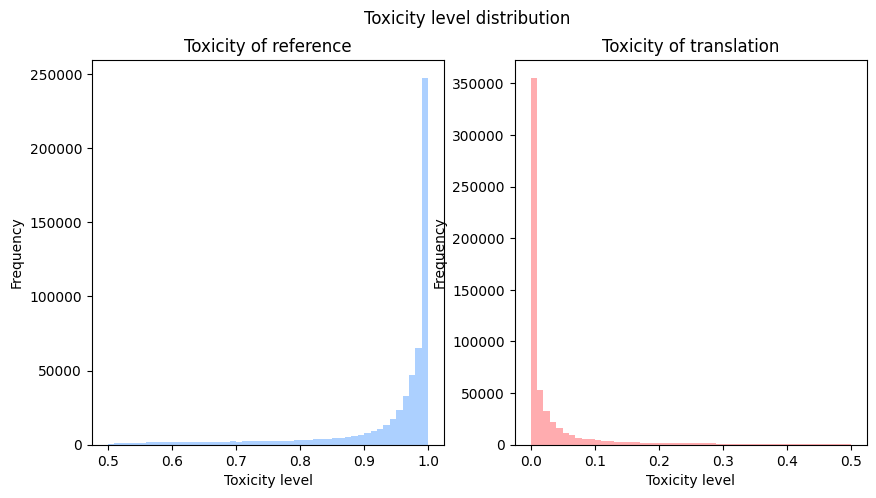

In [13]:
plot_tox_levels(preprocessed_df, columns=['ref_tox', 'detox_ref_tox'])

As observed after the preprocessing, non-toxic sentences tend to have a toxicity level ranging from **0** to **0.1**, while toxic sentences mostly have a toxicity level between **0.9** and **1.0**. 

Since for training the model it is best to have sample with high toxicity level and its paraphrazed version with low toxicity level, let's filter the dataset in order to have:

- Reference (toxic) sentences with toxicity level between **0.9** and **1.0**;
- Non-toxic sentences with toxicity level from **0** to **0.1**.


In [14]:
preprocessed_df = preprocessed_df.query('detox_ref_tox <= 0.1 and ref_tox >= 0.9')
preprocessed_df.reset_index(drop=True, inplace=True)

len(preprocessed_df)

424347

## Analyzing text features

### Relative length difference

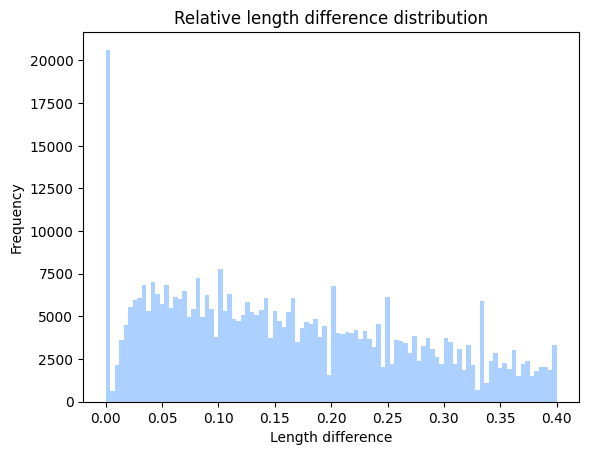

In [15]:
# Plot the relative length difference distribution
def plot_length_diff(df, bins=100):
    plt.hist(df['lenght_diff'], alpha=0.6, bins=bins, color='#75b1ff')
    plt.title('Relative length difference distribution')
    plt.xlabel('Length difference')
    plt.ylabel('Frequency')
    plt.show()
    
    
plot_length_diff(preprocessed_df)

The relative length difference is **0-0.4**, hence the reference and translation have fairly similar sentence lenghts.

### Term Frequency Analysis

In order to perform term frequency analysis, it is crucial to preprocess the text data:
- Convert to lowercase;
- Remove punctuation;
- Perform tokenization;
- Eliminate stopwords.


In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Preprocessing function
def clean(text):
    # lower case
    text = text.lower()
    
    # remove numbers and punctuations
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[^a-z|\s]+', ' ', text)
    
    # tokenize
    tokenized_text = word_tokenize(text)
    
    # remove stopwords
    filtered_text = [t for t in tokenized_text if t not in stop_words]
    
    return filtered_text

[nltk_data] Downloading package punkt to /Users/leiluk1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leiluk1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
reference_text = preprocessed_df['reference'].apply(clean)
detox_reference_text = preprocessed_df['detox_reference'].apply(clean)

In [17]:
corpus = []
texts = reference_text.values + detox_reference_text.values
for text in texts:
    corpus += text

In [18]:
most_common_25 = Counter(corpus).most_common(25)
most_common_25

[('like', 47804),
 ('get', 38805),
 ('know', 33014),
 ('shit', 30583),
 ('fucking', 28649),
 ('one', 27591),
 ('want', 27109),
 ('na', 23669),
 ('gon', 21547),
 ('hell', 21299),
 ('man', 21024),
 ('got', 20148),
 ('would', 19884),
 ('fuck', 19263),
 ('think', 19214),
 ('damn', 18935),
 ('go', 18789),
 ('kill', 18183),
 ('going', 17200),
 ('us', 15338),
 ('little', 15079),
 ('said', 14747),
 ('right', 14616),
 ('take', 14509),
 ('back', 14293)]

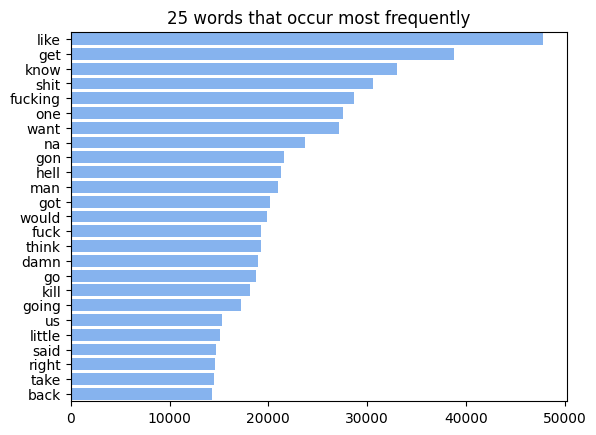

In [19]:
words, freq = [], []
for word, count in most_common_25:
    words.append(word)
    freq.append(count)


sns.barplot(x=freq, y=words, color='#75b1ff')
plt.title('25 words that occur most frequently')
plt.show()

As can be seen, there are bad words such as `shit`, `hell`, `fuck`, etc. that appear in the corpus frequently.